-----

# Etapas que componen el proyecto

## Preparación y Enriquecimiento de los datos
En esta etapa se realizará una primera revisión de los datos que permita comprender cómo se componen los datasets y tener una noción general de la información. Una vez cargada la información y tras realizar algunos planteamientos iniciales, se procederá a recorrer los datos en busca de posibles errores en la información que deban ser solucionados (tipo de objeto, formato, valores duplicados, valores ausentes) 

Luego de haber limpiado y organizado la información, se procederá a añadir campos que permitan o faciliten la resolución de dudas, preguntas e hipótesis con base en los datos iniciales

## Cálculo de métricas e informes
Después de haber organizado los datos para su análisis, se procederá a agrupar la información de la manera más conveniente de tal modo que permita comenzar a responder los planteamientos y que se puedan comenzar a incluir gráficas que faciliten el análisis estadístico y de negocio con la información disponible

### Métricas de Visitas
### Métricas de Ordenes
### Métricas de Marketing


## Conclusiones generales
---------------

# Descripción de los datos
- **Tabla Visits** (Registros del servidor con datos sobre las visitas al sitio web):

    - **uid**: identificador único del usuario

    - **device**: dispositivo del usuario

    - **start ts**: fecha y hora de inicio de la sesión

    - **end ts**: fecha y hora de término de la sesión

    - **source Id**: identificador de la fuente de anuncios de la que proviene el usuario


- **Tabla Orders** (datos sobre pedidos):

    - **uid**: identificador único del usuario que realiza un pedido

    - **buy ts**: fecha y hora del pedido

    - **revenue**: el ingreso de Showz por el pedido


- **Tabla Costs** (datos sobre gastos de marketing):

    - **source_id**: identificador de la fuente de anuncios
    
    - **dt**: fecha
    
    - **costs**: gastos en esta fuente de anuncios en este día

--------------

# 1. Preparación y enriquecimiento de los datos

In [1]:
# Carga de librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math

# 1.1 Preparación de Visitas

In [2]:
# Carga de archivo de Visitas y revisión inicial

visits = pd.read_csv('/datasets/visits_log_us.csv')

print(visits.info())
print()
display(visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None



,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
# Preparación de datos

# Cambio de formato de columnas
visits.columns = visits.columns.str.strip().str.replace(' ','_').str.lower()

# Cambio de formato de fechas
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

# Cambio de formato de identificadores de usuario
visits['uid'] = visits['uid'].astype('str')

# Cambio de orden de columnas
visits = visits[['uid','start_ts','end_ts','source_id','device']]

# Calculo de primera fecha de interacción
cohort = visits.groupby('uid')['start_ts'].min().reset_index()
cohort['first_interaction_date'] = pd.to_datetime(cohort['start_ts'].dt.date)
cohort['first_interaction_month'] = cohort['start_ts'].astype('datetime64[M]')
cohort = cohort[['uid','first_interaction_date','first_interaction_month']]

visits = visits.merge(cohort, on='uid')

print(f'Total de filas duplicadas: {visits.duplicated().sum()}')
print()
print(visits.info())
print()
display(visits.head())

Total de filas duplicadas: 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359400 entries, 0 to 359399
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   uid                      359400 non-null  object        
 1   start_ts                 359400 non-null  datetime64[ns]
 2   end_ts                   359400 non-null  datetime64[ns]
 3   source_id                359400 non-null  int64         
 4   device                   359400 non-null  object        
 5   first_interaction_date   359400 non-null  datetime64[ns]
 6   first_interaction_month  359400 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(1), object(2)
memory usage: 21.9+ MB
None



,uid,start_ts,end_ts,source_id,device,first_interaction_date,first_interaction_month
0,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,4,touch,2017-12-20,2017-12-01
1,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,2,desktop,2018-02-19,2018-02-01
2,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,5,touch,2017-07-01,2017-07-01
3,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00,9,desktop,2018-03-09,2018-03-01
4,16174680259334210214,2018-03-09 20:05:00,2018-03-09 20:33:00,4,desktop,2018-03-09,2018-03-01


Comentarios:
1. Los nombres de columna fueron estandarizados a snake_case para facilitar su uso más adelante en el proyecto. Adicionalmente, se regorganizaron las columnas para facilitar la lectura de la tabla
2. Los datos de la columna "uid" fueron convertidos a tipo string para evitar confundir estos identificadores con números puesto que no se deberían poder realizar operaciones con dichos identificadores
3. Los datos de las columnas de inicio y fin de sesión fueron convertidos a formato de fecha para la futura extracción de información de estos
4. Se añadió una columna con el mes de la primera interacción para cada usuario
5. No se encontraron valores ausentes ni filas duplicadas en el conjunto de datos
-----------

# 1.2 Preparación de Ordenes

In [4]:
# Carga de archivo de Ordenes y revisión inicial

orders = pd.read_csv('/datasets/orders_log_us.csv')

print(orders.info())
print()
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None



,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [5]:
# Preparación de datos

# Cambio de formato de columnas
orders.columns = orders.columns.str.strip().str.replace(' ','_').str.lower()

# Cambio de formato de fechas
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

# Cambio de formato de identificadores de usuario
orders['uid'] = orders['uid'].astype('str')

# Cambio de orden de columnas
orders = orders[['uid','buy_ts','revenue']]

# Calculo de primera fecha de compra
cohort = orders.groupby('uid')['buy_ts'].min().reset_index()
cohort['first_purchase_date'] = pd.to_datetime(cohort['buy_ts'].dt.date)
cohort['first_purchase_month'] = cohort['buy_ts'].astype('datetime64[M]')
cohort = cohort[['uid','first_purchase_date','first_purchase_month']]

orders = orders.merge(cohort, on='uid')
orders['purchase_date'] = pd.to_datetime(orders['buy_ts'].dt.date)
orders['purchase_month'] = orders['purchase_date'].astype('datetime64[M]')
orders = orders[['uid', 'buy_ts', 'revenue', 'purchase_date', 'purchase_month', 'first_purchase_date','first_purchase_month']]

print(f'Total de filas duplicadas: {orders.duplicated().sum()}')
print()
print(orders.info())
print()
display(orders.head())

Total de filas duplicadas: 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   uid                   50415 non-null  object        
 1   buy_ts                50415 non-null  datetime64[ns]
 2   revenue               50415 non-null  float64       
 3   purchase_date         50415 non-null  datetime64[ns]
 4   purchase_month        50415 non-null  datetime64[ns]
 5   first_purchase_date   50415 non-null  datetime64[ns]
 6   first_purchase_month  50415 non-null  datetime64[ns]
dtypes: datetime64[ns](5), float64(1), object(1)
memory usage: 3.1+ MB
None



,uid,buy_ts,revenue,purchase_date,purchase_month,first_purchase_date,first_purchase_month
0,10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,16109239769442553005,2017-06-01 00:29:00,0.55,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,14200605875248379450,2017-06-01 07:58:00,0.37,2017-06-01,2017-06-01,2017-06-01,2017-06-01


Comentarios:
1. Los nombres de columna fueron estandarizados a snake_case para facilitar su uso más adelante en el proyecto. Adicionalmente, se regorganizaron las columnas para facilitar la lectura de la tabla
2. Los datos de la columna "uid" fueron convertidos a tipo string para evitar confundir estos identificadores con números puesto que no se deberían poder realizar operaciones con dichos identificadores
3. Los datos de la columna de hora de compra fueron convertidos a formato de fecha para la futura extracción de información de estos
4. Se añadió una columna con el mes de la primera compra para cada usuario
5. No se encontraron valores ausentes ni filas duplicadas en el conjunto de datos
-----------

# 1.3 Preparación de Costos

In [6]:
# Carga de archivo de Costos y revisión inicial

costs = pd.read_csv('/datasets/costs_us.csv')

print(costs.info())
print()
display(costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None



,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [7]:
# Preparación de datos

# Cambio de formato de columnas
costs.columns = costs.columns.str.strip().str.replace(' ','_').str.lower()

# Cambio de formato de fechas
costs['dt'] = pd.to_datetime(costs['dt'])

# Calculo de mes de producción
costs['production_month'] = costs['dt'].astype('datetime64[M]')

print(f'Total de filas duplicadas: {orders.duplicated().sum()}')
print()
print(costs.info())
print()
display(costs.head())

Total de filas duplicadas: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   source_id         2542 non-null   int64         
 1   dt                2542 non-null   datetime64[ns]
 2   costs             2542 non-null   float64       
 3   production_month  2542 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 79.6 KB
None



,source_id,dt,costs,production_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


Comentarios:
1. Los datos de la columna de fecha fueron convertidos a formato de fecha para la futura extracción de información de estos
2. Se añadió una columna de mes de producción que permita agrupar los costos totales por cada mes para realizar el analisis más adelante
3. No se encontraron valores ausentes ni filas duplicadas en el conjunto de datos
-----------

# 2. Calculo de métricas e informes

# 2.1 Métricas de Visitas

Promedio de usuarios activos por día: 907


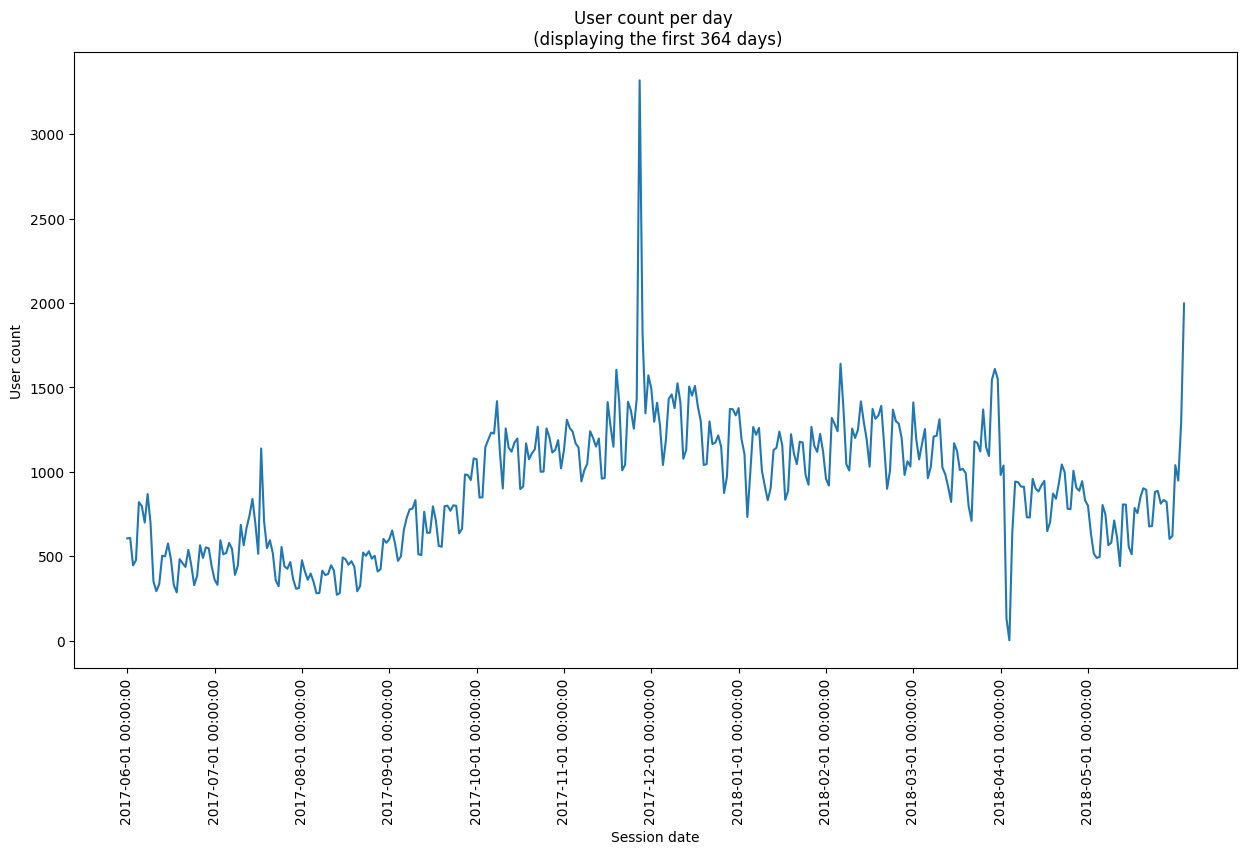


Promedio de usuarios activos por semana: 5716


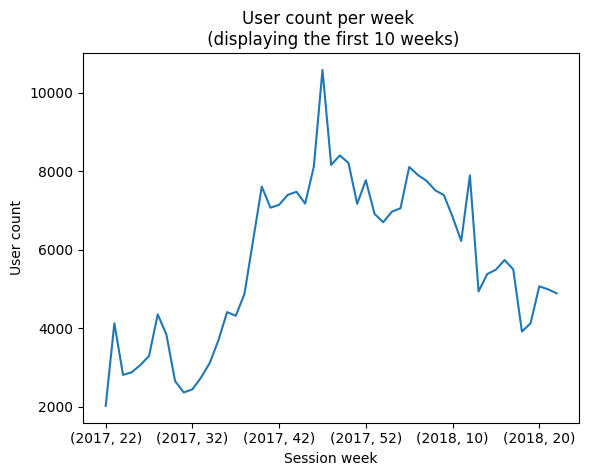


Promedio de usuarios activos por mes: 23228


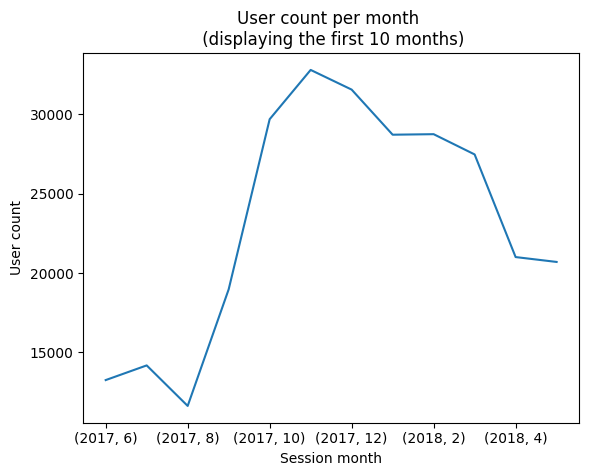

In [8]:
#¿Cuántas personas lo usan cada día, semana y mes?

# Creación de columnas con temporalidades de agrupación
visits['session_day'] = pd.to_datetime(visits['start_ts'].dt.date)
visits['session_week'] = (visits['start_ts'].dt.isocalendar().week).astype('int')
visits['session_month'] = visits['start_ts'].dt.month
visits['session_year'] = (visits['start_ts'].dt.isocalendar().year).astype('int')

# Cálculo de usuarios y sesiones diarios
daily = visits.groupby(['session_year','session_day']).agg({'uid':['count','nunique']})
daily.columns = ['session_count','user_count']
dau = daily['user_count'].mean()

# Cálculo de usuarios y sesiones por semana
monthly = visits.groupby(['session_year','session_month']).agg({'uid':['count','nunique']})
monthly.columns = ['session_count','user_count']
mau = monthly['user_count'].mean()

# Cálculo de usuarios y sesiones por mes
weekly = visits.groupby(['session_year','session_week']).agg({'uid':['count','nunique']})
weekly.columns = ['session_count','user_count']
wau = weekly['user_count'].mean()

# Gráfica de usuarios activos por día
print(f'Promedio de usuarios activos por día: {math.floor(dau)}')

daily.reset_index(inplace=True)

day_count = daily['session_day'].nunique()

daily['user_count'].head(day_count).plot(x='session_day', kind='line', xlabel='Session date', ylabel='User count', 
                                         title=f'User count per day \n (displaying the first {day_count} days)', 
                                         figsize=(15,8), rot=90)

ticks = []
for date in daily['session_day'].astype('datetime64[M]').unique():
    date = pd.to_datetime(date, format="%Y-%m-%d")
    ticks.append(date)     
        
plt.xticks(np.arange(0, 360, 30, dtype='int'), ticks[:13])
plt.show()
print()

# Gráfica de usuarios activos por semana
print(f'Promedio de usuarios activos por semana: {math.floor(wau)}')
weekly['user_count'].plot(x='session_month', kind='line', xlabel='Session week', ylabel='User count', 
                          title='User count per week \n (displaying the first 10 weeks)')
plt.show()
print()

# Gráfica de usuarios activos por mes
print(f'Promedio de usuarios activos por mes: {math.floor(mau)}')
monthly['user_count'].plot(x='session_month', kind='line', xlabel='Session month', ylabel='User count', 
                           title='User count per month \n (displaying the first 10 months)')
plt.show()

Promedio de sesiones abiertas por día: 987
Promedio de sesiones abiertas por usuario cada día: 1.1


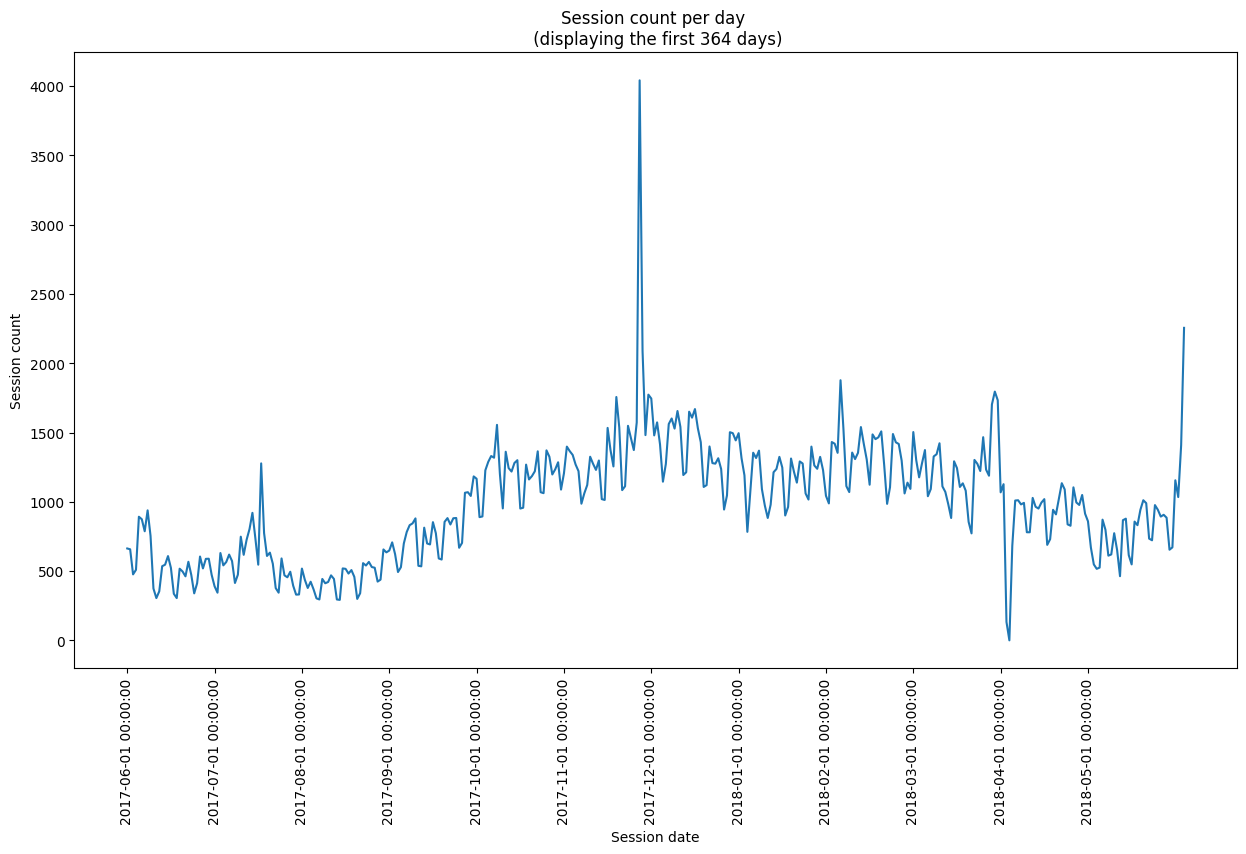

In [9]:
#¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión).

# Gráfica de sesiones activas por día
daily_sessions = daily['session_count'].mean()
print(f'Promedio de sesiones abiertas por día: {math.floor(daily_sessions)}')
print(f'Promedio de sesiones abiertas por usuario cada día: {round(daily_sessions/dau,1)}')

daily.reset_index(inplace=True)

day_count = daily['session_day'].nunique()

daily['session_count'].plot(x='session_day', kind='line', xlabel='Session date', ylabel='Session count', 
                                            title=f'Session count per day \n (displaying the first {day_count} days)', 
                                            figsize=(15,8), rot=90)

ticks = []
for date in daily['session_day'].astype('datetime64[M]').unique():
    date = pd.to_datetime(date, format="%Y-%m-%d")
    ticks.append(date)     
        
plt.xticks(np.arange(0, 360, 30, dtype='int'), ticks[:12])
plt.show()
print()

Duración promedio por sesión: 643.5 sec.


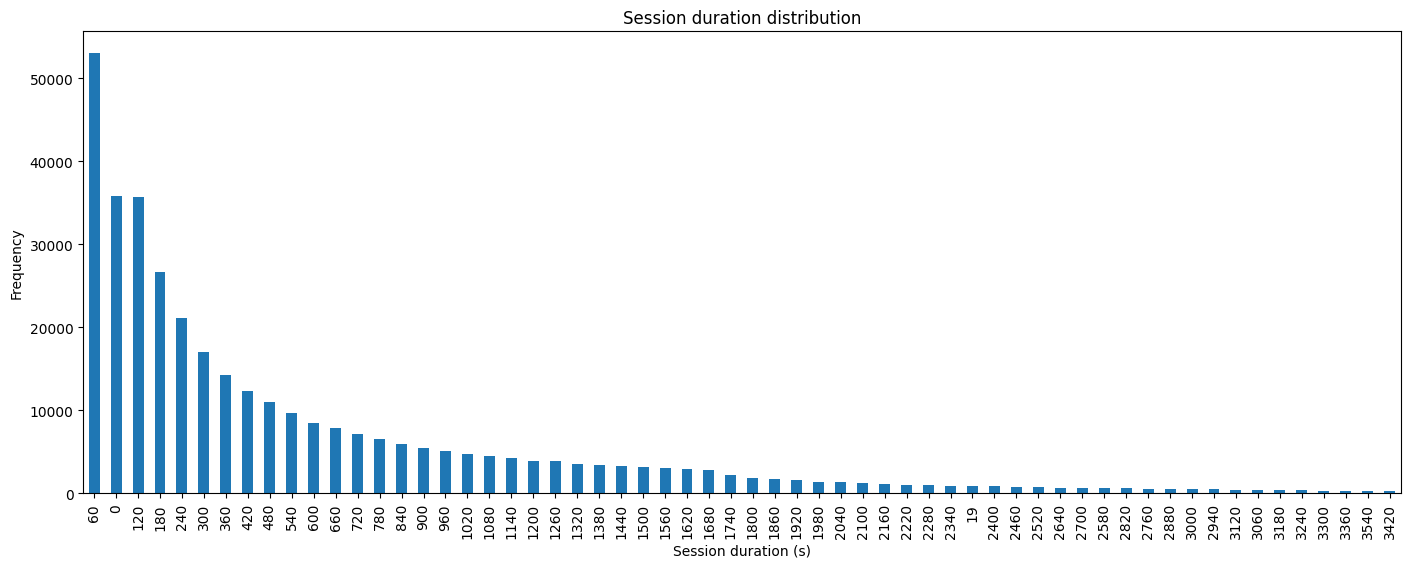

In [10]:
#¿Cuál es la duración de cada sesión?

visits['session_dur'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
session_dur = visits['session_dur'].mean()
print(f'Duración promedio por sesión: {round(session_dur,1)} sec.')

grouped_visits = visits.groupby('session_dur')['uid'].count().sort_values(ascending=False)

grouped_visits.head(60).plot(xlabel='Session duration (s)', ylabel='Frequency', kind='bar',
                             title='Session duration distribution', 
                             figsize=(17,6))
plt.show()

In [11]:
#¿Con qué frecuencia los usuarios regresan?

adherencia_semanal = dau*100/wau
adherencia_mensual = dau*100/mau

print(f'Frecuencia de retorno calculada con base semanal: {round(adherencia_semanal,2)}%')
print(f'Frecuencia de retorno calculada con base mensual: {round(adherencia_mensual,2)}%')

Frecuencia de retorno calculada con base semanal: 15.88%
Frecuencia de retorno calculada con base mensual: 3.91%


# 2.2 Métricas de Ventas

   daily_lifetime  purchase_count
0               0             363
1               1             347
2               2             284
3               3             228
4               4             220
5               5             193
6               6             175
7               7             154
8               8             144
9               9             123


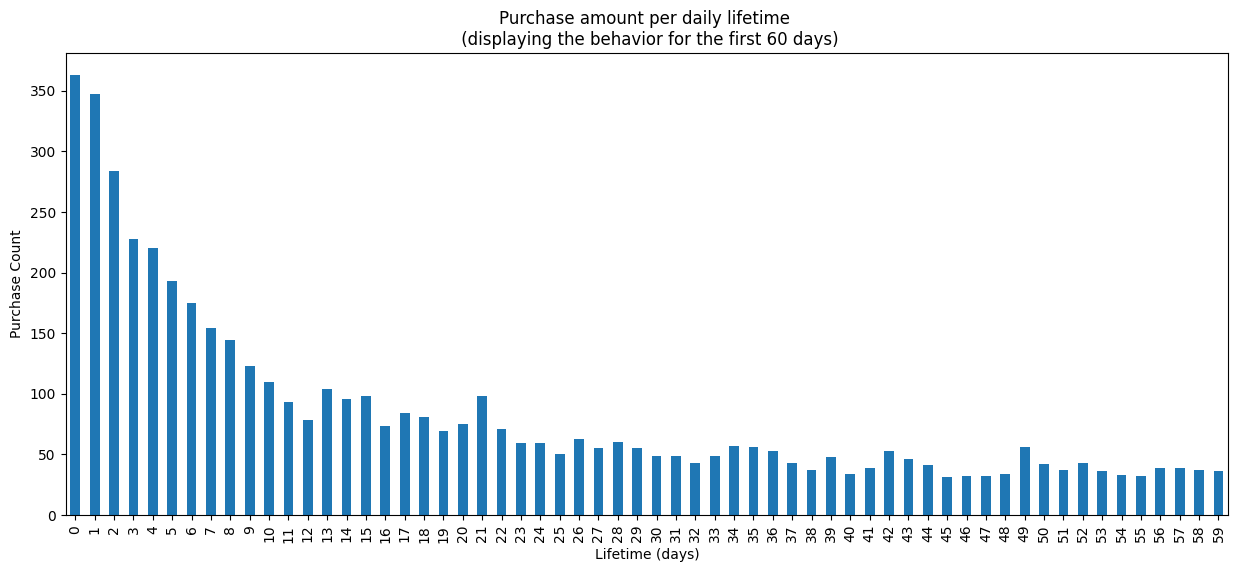

In [16]:
# ¿Cuándo empieza la gente a comprar? 

# Creación de cohortes por día
grouped_orders = (orders.groupby('uid')
                  .agg({'first_purchase_date':'min','first_purchase_month':'min','revenue':'mean'})
                  .reset_index())

first_purchase = visits.merge(grouped_orders, on='uid', how='right')

first_purchase.dropna(inplace=True)
first_purchase.drop_duplicates(subset='uid', inplace=True)

# Cálculo de días transcurridos desde el registro hasta la primera compra
first_purchase['daily_lifetime'] = ((first_purchase['first_purchase_date']-first_purchase['first_interaction_date'])/np.timedelta64(1,'D')).astype('int')

# Cálculo de compras por días transcurridos
purchase_start = first_purchase.groupby('daily_lifetime')['first_purchase_date'].nunique().reset_index(name='purchase_count')
print(purchase_start.head(10))

purchase_start['purchase_count'].head(60).plot(kind='bar', rot=90, xlabel='Lifetime (days)', ylabel='Purchase Count', title='Purchase amount per daily lifetime \n (displaying the behavior for the first 60 days)', figsize=(15,6))
plt.show()

# -------------------------------------------------------------

# Código realizando las correcciones según las indicaciones del revisor

# primera_visita = visits.groupby('uid')['first_interaction_date'].min().reset_index()
# primera_compra = orders.groupby('uid')['first_purchase_date'].min().reset_index()

# merged = primera_visita.merge(primera_compra, on='uid')

# merged['daily_lifetime'] = ((merged['first_purchase_date']-merged['first_interaction_date'])/np.timedelta64(1,'D')).astype('int')

# # Cálculo de días transcurridos hasta la primera compra
# purchase_start = merged.groupby('daily_lifetime')['first_purchase_date'].nunique().reset_index(name='purchase_count')
# print(purchase_start.head(10))

Comentarios:
1. Se logró identificar que no todos los usuarios que se han registrado en la platforma han realizado compras, razón por la cual se optó por contemplar unicamente a los usuarios que se convirtieron en clientes para realizar el cálculo de métricas
2. Se puede evidenciar que los clientes suelen comenzar a realizar compras entre los días 0 y 1
3. El mayor volumen de compras suele darse durante los primeros 5 días de actividad

Promedio de pedidos realizados por cada cohorte a lo largo de su vida: 90



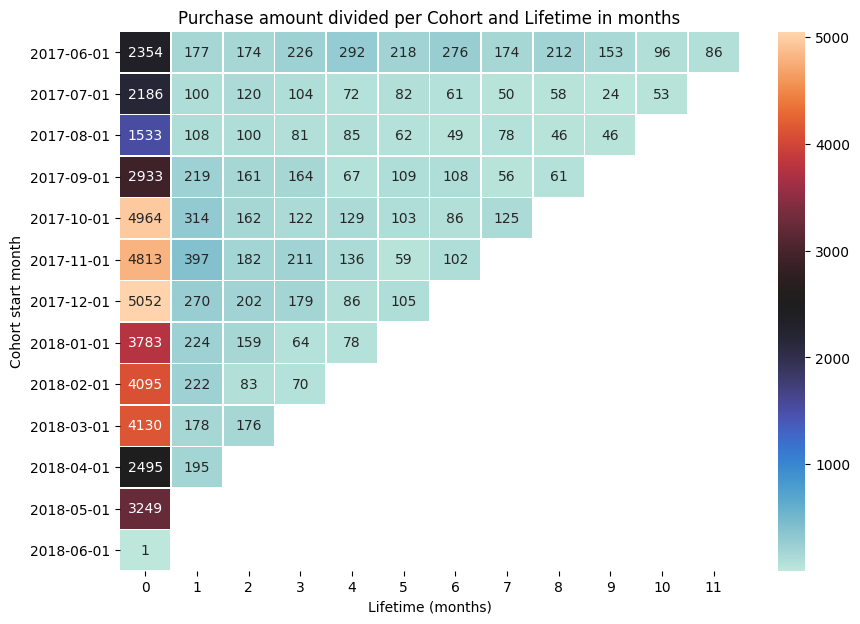

In [18]:
# ¿Cuántos pedidos hacen durante un período de tiempo dado?

purchase_count = orders.groupby(['first_purchase_month','purchase_month'])['uid'].count().reset_index(name='monthly_purchases')
 
# Creación de cohortes por mes
purchase_count['monthly_lifetime'] = ((purchase_count['purchase_month']-purchase_count['first_purchase_month'])/np.timedelta64(1,'M')).round().astype('int')
purchase_count['first_purchase_month'] = purchase_count['first_purchase_month'].dt.date

#Cálculo de pedidos
purchase_pivot = purchase_count.pivot_table(index='first_purchase_month',
                                           columns='monthly_lifetime',
                                           values='monthly_purchases',
                                           aggfunc='sum')

print(f'Promedio de pedidos realizados por cada cohorte a lo largo de su vida: {math.floor((purchase_pivot.median()).median())}')
print()

plt.figure(figsize=(10,7))
sns.heatmap(purchase_pivot,
            annot=True,
            fmt='.0f',
            linewidths=0.3,
            cmap='icefire')

plt.title('Purchase amount divided per Cohort and Lifetime in months')
plt.xlabel('Lifetime (months)')
plt.ylabel('Cohort start month')
plt.show()

Comentarios:
1. Para el cálculo del tamaño promedio de compra se optó por utilizar la mediana en lugar de la media debido a la presencia de valores atípicos
2. Se puede apreciar que la mayoria de cohortes presentan un pico de actividad durante el primer mes para luego, en el segundo mes, descender a niveles que rondan el 10% del mes anterior

Tamaño promedio de compra: $6.29



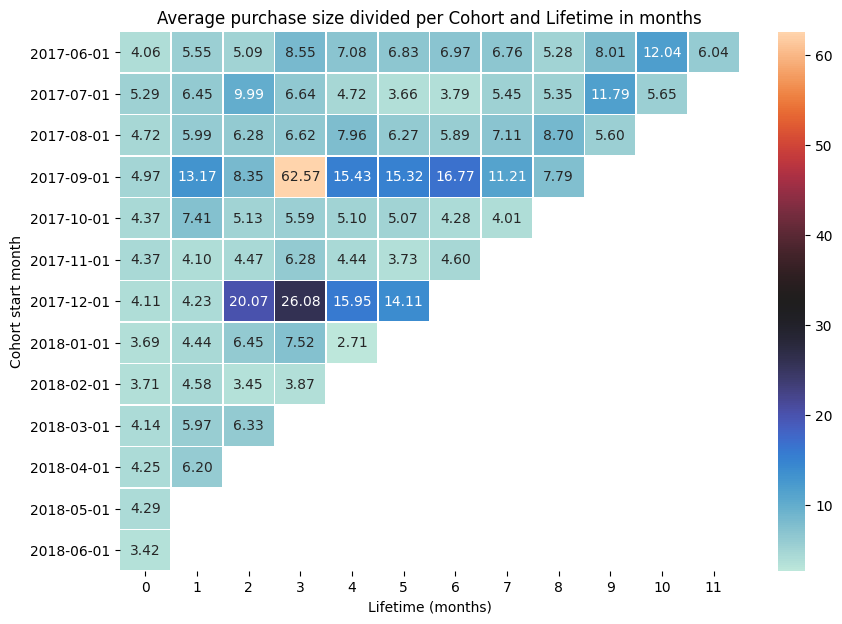

In [17]:
# ¿Cuál es el tamaño promedio de compra?

purchases = orders.groupby(['first_purchase_month','purchase_month']).agg({'uid':'count','revenue':'sum'}).reset_index()
purchases.rename(columns={'uid':'monthly_purchases','revenue':'monthly_profit'}, inplace=True)
purchases['revenue_per_user'] = purchases['monthly_profit']/purchases['monthly_purchases']

# Creación de cohortes por mes
purchases['monthly_lifetime'] = ((purchases['purchase_month']-purchases['first_purchase_month'])/np.timedelta64(1,'M')).round().astype('int')
purchases['first_purchase_month'] = purchases['first_purchase_month'].dt.date

purchase_pivot = purchases.pivot_table(index='first_purchase_month',
                                       columns='monthly_lifetime',
                                       values='revenue_per_user',
                                       aggfunc='mean').round(2)

print(f'Tamaño promedio de compra: ${(purchase_pivot.median()).median().round(2)}')
print()

plt.figure(figsize=(10,7))
sns.heatmap(purchase_pivot,
            annot=True,
            fmt='.2f',
            linewidths=0.3,
            cmap='icefire')

plt.title('Average purchase size divided per Cohort and Lifetime in months')
plt.xlabel('Lifetime (months)')
plt.ylabel('Cohort start month')
plt.show()

Comentarios:
1. Para el cálculo del tamaño promedio de compra se optó por utilizar la mediana en lugar de la media debido a la presencia de valores atípicos
2. Se puede apreciar que, en terminos generales, el promedio de compra para cada cohorte no suele variar sustancialmente a lo largo del tiempo
3. En terminos generales, la cohorte iniciada en 2017-09-01 es la que suele generar compras promedio mayores que las demás cohortes

LTV promedio mensual: $7.57 por cohorte



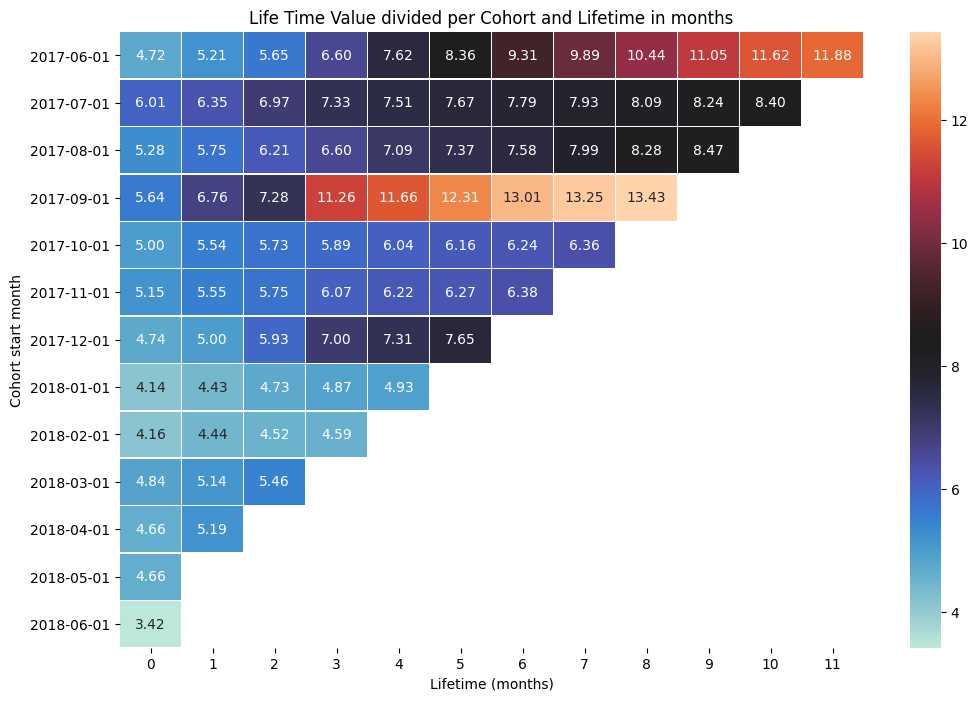

,average_LTV_per_cohort
monthly_lifetime,
0,4.801538
1,5.396364
2,5.823000
3,6.690000
4,7.297500
5,7.970000
6,8.385000
7,9.084000
8,10.060000


In [19]:
# ¿Cuánto dinero traen? (LTV)

# Calculo de LTV
purchases['first_purchase_month'] = pd.to_datetime(purchases['first_purchase_month'])
users = orders.groupby('first_purchase_month')['uid'].nunique().reset_index(name='cohort_user_count')
ltv = purchases.merge(users, on='first_purchase_month')

ltv['LTV'] = ltv['monthly_profit']/ltv['cohort_user_count']

ltv['first_purchase_month'] = ltv['first_purchase_month'].dt.date

ltv_report = ltv.pivot_table(index='first_purchase_month',
                             columns='monthly_lifetime',
                             values='LTV',
                             aggfunc='mean').round(2)

print(f'LTV promedio mensual: ${(ltv_report.sum()).mean().round(2)} por cohorte')
print()

plt.figure(figsize=(12,8))
sns.heatmap(ltv_report.cumsum(axis=1),
            annot=True,
            fmt='.2f',
            linewidths=0.3,
            cmap='icefire')

plt.title('Life Time Value divided per Cohort and Lifetime in months')
plt.xlabel('Lifetime (months)')
plt.ylabel('Cohort start month')
plt.show()

display(ltv_report.cumsum(axis=1).mean(axis=0).reset_index(name='average_LTV_per_cohort').set_index('monthly_lifetime'))

Comentarios:
1. Se logró identificar que el LTV promedio por cohorte es de $7.57 a lo largo de su ciclo de vida

# 2.3 Métricas de Marketing

In [ ]:
#¿Cuánto dinero se gastó?  (Total/por fuente de adquisición/a lo largo del tiempo) 

grouped_costs = costs.groupby(['production_month','source_id'])['costs'].sum().reset_index(name='monthly_cost')
grouped_costs['production_month'] = grouped_costs['production_month'].dt.date

costs_report = grouped_costs.pivot_table(index='production_month',
                                         columns='source_id',
                                         values='monthly_cost',
                                         aggfunc='sum').round(2)

costs_report.plot(xlabel='Production month', 
                  ylabel='Total costs (USD)', 
                  title='Total monthly costs divided per Source ID')
plt.legend(title='Source ID')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(costs_report,
            annot=True,
            fmt='.2f',
            linewidths=0.3,
            cmap='icefire')

plt.title('Total monthly costs divided per Source ID')
plt.xlabel('Source ID')
plt.ylabel('Production Month')
plt.show()

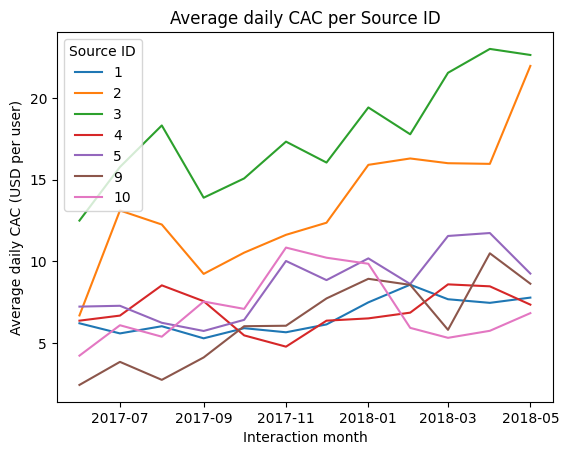

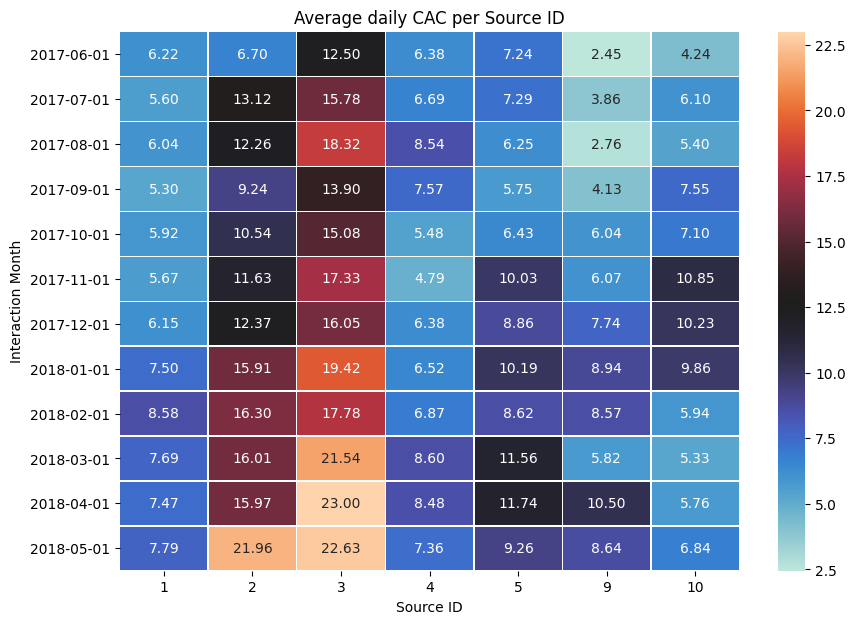

In [20]:
#¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?

# Obtención del medio de adquisición del usuario
user_source = visits.sort_values(by='first_interaction_date').groupby(['uid','first_interaction_month','first_interaction_date'])['source_id'].first().reset_index()

# Unión de dataset de medio con datasets con información de primeras compras
grouped_source = orders.merge(user_source, on='uid')
grouped_source.dropna(inplace=True)
grouped_source.drop_duplicates(inplace=True)
grouped_source.drop(columns=['buy_ts','purchase_date','purchase_month'], inplace=True)

# Conteo de usuarios   
grouped_source = grouped_source.groupby(['source_id','first_interaction_month','first_interaction_date'])['uid'].nunique().reset_index(name='daily_customer_count')

# Unión de conteo y costos
report = grouped_source.merge(costs, 
                              left_on=['source_id','first_interaction_date'], 
                              right_on=['source_id','dt'])

report['first_interaction_month'] = report['first_interaction_month'].dt.date

# Cálculo de CAC y gráficos
report['daily_CAC'] = report['costs']/report['daily_customer_count']

cac_report = report.pivot_table(index='first_interaction_month',
                                columns='source_id',
                                values='daily_CAC',
                                aggfunc='mean').round(2)

cac_report.plot(xlabel='Interaction month', ylabel='Average daily CAC (USD per user)', title='Average daily CAC per Source ID')
plt.legend(title='Source ID')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cac_report,
            annot=True,
            fmt='.2f',
            linewidths=0.3,
            cmap='icefire')

plt.title('Average daily CAC per Source ID')
plt.xlabel('Source ID')
plt.ylabel('Interaction Month')
plt.show()

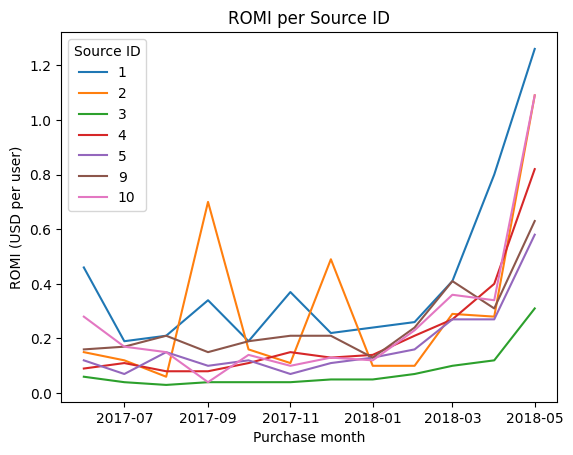

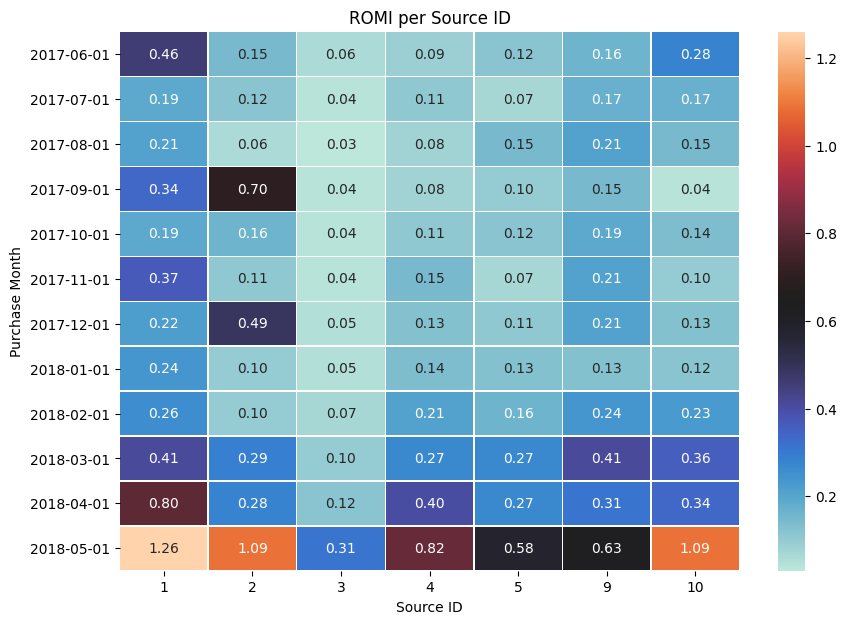

In [23]:
# ¿Cuán rentables eran las inversiones? (ROMI)

# Obtención del medio de adquisición del usuario
grouped_source = orders.merge(user_source, on='uid')
grouped_source.dropna(inplace=True)
grouped_source.drop(columns=['buy_ts','purchase_date','first_purchase_date','first_interaction_date'], inplace=True)

# Cálculo de cohorte, tamaño de cohorte y ganancias mensuales agrupadas por medio y cohorte
grouped_source['monthly_lifetime'] = ((grouped_source['purchase_month']-grouped_source['first_purchase_month'])/np.timedelta64(1,'M')).round().astype('int')

users = grouped_source.groupby(['source_id','first_purchase_month'])['uid'].nunique().reset_index(name='cohort_initial_size')
revenue = grouped_source.groupby(['source_id','first_purchase_month','monthly_lifetime'])['revenue'].sum().reset_index(name='monthly_profit')

grouped_source = users.merge(revenue, on=['source_id','first_purchase_month'])

# Unión de costos y cohortes
grouped_costs = costs.groupby(['source_id','production_month'])['costs'].sum().reset_index(name='monthly_costs')

report = grouped_source.merge(grouped_costs, 
                              left_on=['source_id','first_purchase_month'], 
                              right_on=['source_id','production_month'])

report['first_purchase_month'] = report['first_purchase_month'].dt.date

# Cálculo de LTV, CAC y ROMI mensual
report['LTV'] = report['monthly_profit']/report['cohort_initial_size']
report['CAC'] = report['monthly_costs']/report['cohort_initial_size']
report['ROMI'] = report['LTV']/report['CAC']

# Gráficas
romi_report = report.pivot_table(index='first_purchase_month',
                                columns='source_id',
                                values='ROMI',
                                aggfunc='mean').round(2)

romi_report.plot(xlabel='Purchase month', ylabel='ROMI (USD per user)', title='ROMI per Source ID')
plt.legend(title='Source ID')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(romi_report,
            annot=True,
            fmt='.2f',
            linewidths=0.3,
            cmap='icefire')

plt.title('ROMI per Source ID')
plt.xlabel('Source ID')
plt.ylabel('Purchase Month')
plt.show()

-------------------------
# 3. Conclusiones generales

1. Se estima que el promedio de usuarios activos al día es de 907 y que las sesiones activas en promedio son 987, lo cuál implica un nivel de actividad de aproximadamente 1.1 sesiones diarias por usuario
2. Se logró evidenciar que el volumen de compras durante los primeros 5 días dentro de la plataforma suele encontrarse por encima de 200, mientras que después de dicho periodo comienzan a disminuir las compras hasta alcanzar niveles inferiores a 100 compras por día a partir del día 10
3. A partir del análisis, se obtuvo que la primera cohorte es la que mayor fidelidad ha mostrado a lo largo del tiempo basados en su volumen de ordenes
4. Se identificó un promedio de compra por cohorte de \$7.29
5. Al realizar el cálculo del LTV se identificó que cada usuario aporta un promedio mensual de $37.85
6. Al realizar el análisis de costos de distribución se logró identificar que los 4 medios de adquisición que más costos representan, organizados de mayor a menor, son: 3, 4, 5 y 2
7. En contraposición, los medios de adquisición más económicos, organizados de mayor a menos, son: 9, 10 y 1. Cabe resaltar que los medios 9 y 10 mostraron comportamientos bastante similares
8. Independiente del medio de adquisición, se evidenció una disminución en el ROMI a medida que avanza el tiempo. Este análisis es consistente con la evidencia sobre la disminución de compras promedio a lo largo del tiempo
9. Los medios 2 y 3 demuestran tener una rentabilidad bastante similar aunque se encuentran dentro de los tres menos rentables junto con el medio 1
10. Los medios más rentables a lo largo del tiempo demuestran ser el 5, 9 y 10, teniendo todos a su vez un comportamiento bastante similar